In [1]:
import matplotlib_inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.size"] = 20

# load the stock data

In [7]:

import os
import yaml
import pandas as pd
from glob import glob
import numpy as np
from halo import Halo

header = [
    "对象id",  # 0
    "交易日期",  # 1  
    "WIND代码",  # 2
    "公司名称",  # 3
    "上市日期",  # 4
    "退市日期",  # 5
    "ST",  # 6
    "中信一级行业指数代码",  # 7
    "中信二级行业指数代码",  # 8
    "中信三级行业指数代码",  # 9
    "中信一级行业指数名称",  # 10
    "中信二级行业指数名称",  # 11
    "中信三级行业指数名称",  # 12
    "进入中信指数日期",  # 13
    "停牌",  # 14
    "涨跌停标志",  # 15
    "昨日收盘价",  # 16
    "开盘价",  # 17
    "收盘价",  # 18
    "最低价",  # 19
    "最高价",  # 20
    "成交量",  # 21
    "成交金额",  # 22
    "复权因子",  # 23
    "当日总股本",  # 24
    "当日流通股本", # 25
    "当日自由流通股本"  # 26
]
project_path = os.path.dirname(os.path.abspath(os.curdir))
config_file = os.path.join(project_path, "config.yaml")
config = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)
data_root = config["data"]["root"]
print(f"Data root: {data_root}")
processed_data = os.path.join(data_root, "2020A股.csv")

if not os.path.exists(processed_data):
    with Halo(text="Preparing data...(may take about 3 miniutes ...)", spinner="dots", text_color="blue", interval=1000):
        data_file = glob(os.path.join(data_root, "2020*.xlsx"))[0]
        dt = pd.read_excel(data_file)
        dt.to_csv(processed_data, index=False)
else:
    data = pd.read_csv(processed_data)

simplified_data = "simplified.csv"
if not os.path.exists(simplified_data):
    simplified_dt = data[["对象id", "WIND代码", "收盘价", "开盘价", "最高价", "最低价", "成交量"]]
    simplified_dt.to_csv(simplified_data, index=False)


Data root: /home/fanqiliang/data/stock


In [11]:
num_company = data["WIND代码"].unique().shape[0]
comp_wind_id = pd.DataFrame(data["WIND代码"].unique().tolist())
comp_wind_id.to_csv("company_wind_id.csv", index=False, header=False)
print("公司的wind id已经保存到: company_wind_id.csv中...")
num_days = data["交易日期"].unique().shape[0]
date_list = data["交易日期"].unique().tolist()

print(f"公司数量: {num_company}")
print(f"交易记录时长: {num_days}天")

output_dir = os.path.join(data_root, "split")
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for c_id in data["WIND代码"].unique().tolist():
        output_file = os.path.join(output_dir, f"{c_id}.csv")
        dt = simplified_dt[simplified_dt["WIND代码"] == c_id]
        dt.to_csv(output_file, index=False)

公司的wind id已经保存到: company_wind_id.csv中...
公司数量: 4154
交易记录时长: 242天


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


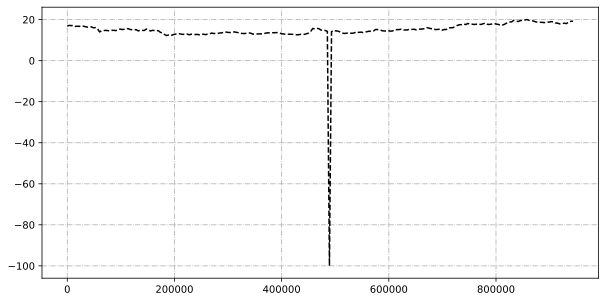

该图为某公司的股价趋势, 可以看到已经经过复权了


In [4]:
%matplotlib inline

for name, comp in data.groupby("WIND代码"):
    values = comp["收盘价"]
    plt.figure(figsize=(10, 5))
    plt.grid(True, linestyle="-.")
    plt.plot(values,  color="black", linestyle="--")
    # plt.savefig("test.png")
    plt.show()
    plt.close()
    break

print("该图为某公司的股价趋势, 可以看到已经经过复权了")

# Download assitance data

In [5]:
import baostock as bs
company_id = pd.read_csv("company_wind_id.csv", header=None).values.squeeze().tolist()
from tqdm.notebook import tqdm

lg = bs.login()

login success!


In [11]:
"""
CFOToOR	经营活动产生的现金流量净额除以营业收入	
CFOToNP	经营性现金净流量除以净利润	
CFOToGr	经营性现金净流量除以营业总收入	
"""

if not os.path.exists("cash_flow_2020.csv"):
    cash_flow_2020 = pd.DataFrame(columns=[
        "wind_id",
        "quater",
        "CFOToOR",
        "CFOToNP",
        "CFOToGr"
    ])

    for comp_id in tqdm(company_id):
        for quarter in range(1, 5):
            res = bs.query_cash_flow_data(code=f"{comp_id}", year=2020, quarter=quarter).get_row_data()
            if len(res) > 0:
                cash_flow_2020 = cash_flow_2020.append({
                    "wind_id": comp_id,
                    "quater": quarter,
                    "CFOToOR": res[-3],
                    "CFOToNP": res[-2],
                    "CFOToGr": res[-1]
                }, ignore_index=True)
            else:
                print(comp_id, quarter)
    cash_flow_2020.to_csv("cash_flow_2020.csv", index=False)

  0%|          | 0/4154 [00:00<?, ?it/s]

000662.SZ 4
000693.SZ 1
000693.SZ 2
000693.SZ 3
000693.SZ 4
002220.SZ 2
002220.SZ 3
002220.SZ 4


KeyboardInterrupt: 